# Cleaning text

This notebook is to clean text (this processing step is applicable to all models and all EDA steps). Some models may have processing steps specific to them.

In [42]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import re

import emoji
import demoji

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans

## Preprocessing of the textual data
Before we begin any modelling and analysis, it is a good idea to preprocess the text, because it is highly unstructured and not easily understood by machines.

We shall perform the following preprocessing steps:

1. Replacing URL's with "url"
2. Replacing emojis with the word representation of them
3. Replacing all user mentions with user_mention
4. Removing all hashtags

We also avoid performing stemming and lemmatization because we may lose key words present in the tweets

In [16]:
#This is the wrapper preprocessing function that is universally applicable to all our text models/eda steps
CLEANR = re.compile('<.*?>') 
#replace the new line characters
def process_text(text):
    txt_lst = text.split()
    
    #A helper function to process emojis
    #Emojis are left in in order to 
    def process_emoji(emo):
        try:
            decoded = emoji.demojize(emo)
            decoded = decoded.replace(":", "")
            return decoded
        except UnicodeDecodeError:
            #if unable to decode emoji, just keep a place holder for it
            return "__emoji__"
    
    #store all emojis as the decoded form
    txt_lst = [process_emoji(x) if emoji.is_emoji(x) else x for x in txt_lst]
    
    #process all tagged accounts
    def process_tagged_accounts(account):
        #replace all tagged accounts with __user_mention__
        if account.startswith("@") and len(account) > 1:
            return "__user_mention__"
        return account
    
    #replace hashtags with place holders
    def process_hashtags(text):
        if text.startswith("#"):
            return "__hashtag__"
        return text
    
    
    #apply the functions above
    txt_lst = [process_tagged_accounts(x) for x in txt_lst]
    txt_lst = [process_hashtags(x) for x in txt_lst]
    
    #next, we process the urls
    def process_urls_html(text):
        pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
        text = re.sub(pattern, "", text)
        text = re.sub(CLEANR, "", text)
        return text
    
    text = " ".join(txt_lst)
    
    final_text = process_urls_html(text)
    return final_text

In [17]:
#read in the bot tweets from the fake followers dataset
bot_tweets_fake = pd.read_csv('bot_tweets_fake_english.csv')

In [18]:
#read in the bot tweets from the social dataset
bot_tweets_social = pd.read_csv('bot_tweets_social_english.csv')

In [19]:
#finally, read in the bot tweets from the human tweets dataset
human_tweets = pd.read_csv('human_tweets_english.csv')

In [20]:
#add another column for the cleaned text
bot_tweets_fake['cleaned_text'] = bot_tweets_fake.text.apply(process_text)

In [21]:
bot_tweets_social['cleaned_text'] = bot_tweets_social.text.apply(process_text)

In [22]:
human_tweets['cleaned_text'] = human_tweets.text.apply(process_text)

In [23]:
#save these datasets to csv files for usage in training models

bot_tweets_fake.to_csv("bot_tweets_fake_processed.csv")
bot_tweets_social.to_csv('bot_tweets_social_processed.csv')
human_tweets.to_csv("human_tweets_processed.csv")

## Exploratory Data Analysis
Here, we perform some simple EDA on the data, namely wordclouds for the different classes and K means clustering. We also perform cosine similarity test to see how different Baf Of Words (BOW) vectors are within and across the classes.

In [24]:
bot1_tweets = pd.read_csv('bot_tweets_fake_processed.csv')
bot2_tweets = pd.read_csv('bot_tweets_social_processed.csv')

#Combine both bot Dataframes
bot_tweets = pd.concat([bot1_tweets, bot2_tweets], axis=0)

#Create human tweets dataframe
human_tweets = pd.read_csv('human_tweets_processed.csv')

In [32]:
bot_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84449 entries, 0 to 42226
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0.2         84449 non-null  int64  
 1   Unnamed: 0.1         84449 non-null  int64  
 2   Unnamed: 0           84449 non-null  int64  
 3   created_at           84449 non-null  object 
 4   id                   84449 non-null  int64  
 5   text                 84449 non-null  object 
 6   source               84449 non-null  object 
 7   user_id              84449 non-null  int64  
 8   retweeted_status_id  0 non-null      float64
 9   retweet_count        84449 non-null  int64  
 10  reply_count          84449 non-null  int64  
 11  favorite_count       84449 non-null  int64  
 12  num_hashtags         84449 non-null  int64  
 13  num_urls             84449 non-null  int64  
 14  num_mentions         84449 non-null  int64  
 15  bot                  84449 non-null 

In [38]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/parathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/parathan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/parathan/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/parathan/nltk_data...


True

In [43]:
# The stopwords module contains a list of words that are commonly used in Engliush but ahve little to no value
stop = list(set(stopwords.words('english')))
# The 'WordNetLemmatizer' is used for reducing words to their base or dictionary form
lemmatizer = WordNetLemmatizer()

#removing these words to get a better idea of the differences in vocab
contextual_stop = ['day','new','one', 'time','need', "__user_mention__", "__hashtag__"]
stop = stop + contextual_stop

#Create a function that plots a word cloud using the tokens
def plot_word_cloud(df):
    df['tokenized'] = df['cleaned_text'].apply(word_tokenize)
    
    df['processed_data'] = df.tokenized.apply(lambda x: [word.casefold() for word in x if word.casefold() not in stop
                                                                    and word not in contextual_stop])
    df['processed_data'] = df.processed_data.apply(lambda x:[lemmatizer.lemmatize(word) for word in x])
    df['sentence'] = df['processed_data'].apply(lambda x:' '.join(x))
    
    big_sentence = ''

    for sentence in df['sentence']:
        big_sentence += sentence

    wordcloud = WordCloud(background_color='white').generate(text = big_sentence)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation = 'bilinear')

In [40]:
bot_tweets['cleaned_text'].apply(word_tokenize)

0        [__user_mention__, do, n't, tweet, 1, hour, ti...
1        [Posted, a, new, song, :, ``, I, 'm, On, My, L...
2        [RT, __user_mention__, Help, __user_mention__,...
3        [I, love, you, !, But, ,, I, bet, you, already...
4        [Lost, a, big, pot, with, kk, ., Guy, flopped,...
                               ...                        
42222    [theawkwardmoment, #, theawkwardmoment, when, ...
42223    [I, will, have, the, rest, of, the, site, upda...
42224    [RT, __user_mention__, Follow, __user_mention_...
42225       [Stupidity, in, numbers, ., penn, state, riot]
42226    [RT, __user_mention__, Website, Rank, |, Searc...
Name: cleaned_text, Length: 84449, dtype: object

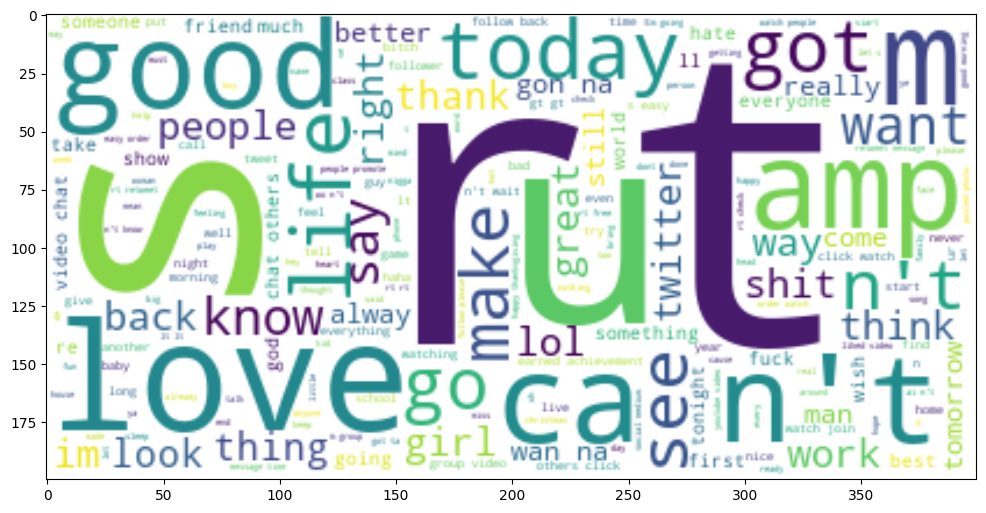

In [44]:
#Word cloud for bots
plot_word_cloud(bot_tweets)

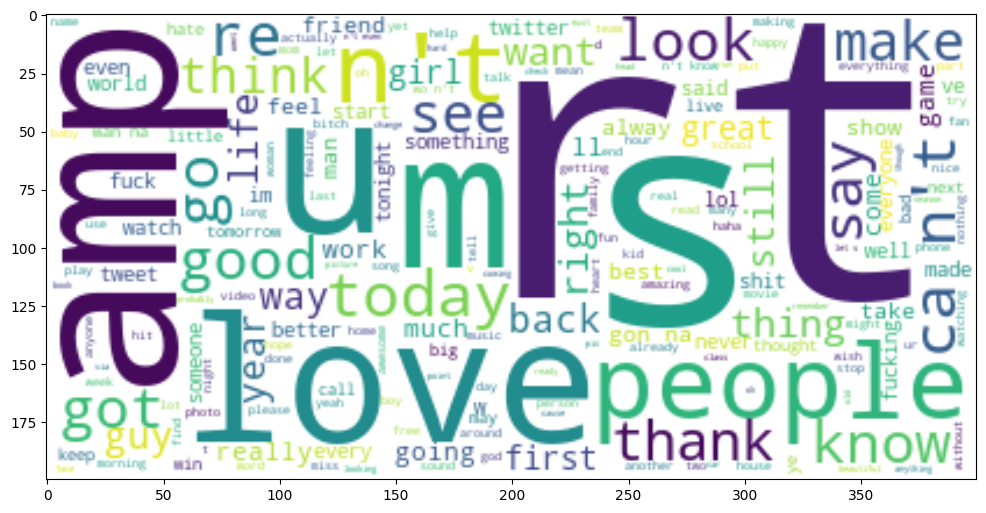

In [45]:
plot_word_cloud(human_tweets)

## Bag of Words model
We shall start off with the simplest model for test classfication, ie a bag of words model, which simply stores the count of each word in the vocabulary for each tweet, which results in a rather sparse representation of each tweet

In [46]:
df_tweets = pd.concat([bot_tweets, human_tweets], axis=0)

In [49]:
#Tokenise the words in the tweet
df_tweets['tokenized'] = df_tweets['cleaned_text'].apply(word_tokenize)

In [51]:
# Get a list of the stopwords
stop = list(stopwords.words('english'))

#Removed stop words
df_tweets['processed_data'] = df_tweets.tokenized.apply(lambda x: [word.casefold() for word in x if word.casefold() not in stop
                                                                    and word not in contextual_stop])
#lemmatize the words
df_tweets['processed_data'] = df_tweets.processed_data.apply(lambda x:[lemmatizer.lemmatize(word) for word in x])

df_tweets['sentence'] = df_tweets['processed_data'].apply(lambda x : " ".join(x))

#Change the sentence to lower case
df_tweets['sentence'] = df_tweets['sentence'].str.lower()

In [52]:
#Now we create the BOW vectors
#Next, we initialize a count vectorizer and transform the text into Bag of Words vectors, if some word appears in more than half, we ignore that word
vectorizer = CountVectorizer(max_df = 0.5, min_df = 10)
#Create an array that contains the BOW representation of each tweet
bow_array  = vectorizer.fit_transform(df_tweets['sentence'])
#Converting the result into a pandas dataframe
bow = pd.DataFrame(bow_array.toarray(),columns = vectorizer.get_feature_names_out())

Before fitting any machine learning models on the BOW vectors, let us see if there are any meaningful clusters in the BOW features. If the BOW features are significantly different between humans and bots, then we should expect to see clusters in which the proportion of bot tweets vs human tweets is significantly different from the normal dataset.

In [53]:
kmeans_df = df_tweets.copy()

#we shall use K = 2 because that is the number of natural clusters in the dataset (bot vs human tweets)
kmeans_bow = KMeans(n_clusters = 2)

kmeans_bow.fit(bow)

In [ ]:
#Extracting the labels and seeing whether there is any meaningful separation in the dataset

kmeans_df['cluster_labels'] = kmeans_bow.labels_

cluster_0 = kmeans_df[kmeans_df.cluster_labels == 0]

#seeing if there proportion of labels is any different as compared to the full dataset
cluster_0['isBot'].value_counts()

#this cluster is quite interesting because most of the tweets are human tweets

In [ ]:
#Let us further investigate this particular cluster
cluster_0.head()